# Installing Dependencies

In [1]:
! pip install -q -U tensorflow-io transformers librosa tensorflow==2.11.0 tf2onnx keras2onnx onnxruntime

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
wfdb 4.1.0 requires SoundFile<0.12.0,>=0.10.0, but you have soundfile 0.12.1 which is incompatible.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


# importing Dependencies

In [2]:
import warnings
import pandas as pd 
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import librosa
device_name = tf.test.gpu_device_name()
device_name
import keras
import tf2onnx
import onnx
import onnxruntime as ort

# Set up file location

In [3]:
for i in os.listdir('/kaggle/input/audio-classifier-dataset/augmented-audio'):
  print(i)

Les Brown
Gary Vee
Simon Sinek
Eric Thomas
Jay Shetty
Mel Robbins
Rabin Sharma
Brene Brown
Nick Vujicic
Oprah Winfrey
Eckhart Tolle


In [4]:
audio_path = '/kaggle/input/audio-classifier-dataset/augmented-audio'

# Set up Hyper parameters 

Here num_classes are number of speakers.

Num_samples = 80000 is sample rate, as audios length are 5s so sample rate for 5s is 80000.

I kept Batch_size is 32, and learning_rate = 0.001

In [5]:
num_classes = 11
num_samples = 80000
num_mel_bins = 128
fft_length = 2048
hop_length = 512
batch_size = 32
learning_rate = 0.001


# Make a list data with labels

In [6]:

audio_files = []
labels = []

labelind = -1
for label in os.listdir(audio_path):
    labelind +=1
    label_path = os.path.join(audio_path, label)
    for audio_file in os.listdir(label_path):
        audio_file_path = os.path.join(label_path, audio_file)
        audio_files.append(audio_file_path)
        labels.append(labelind)


# Preprocess audio file into numeric form

In [7]:

def preprocess_audio(audio_file_path):
    audio, sr = librosa.load(audio_file_path, sr=num_samples)
    if len(audio) > num_samples:
        audio = audio[:num_samples]
    else:
        audio = np.pad(audio, (0, num_samples - len(audio)), 'constant')
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=fft_length, hop_length=hop_length, n_mels=num_mel_bins)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    return abs(mel_spec_db)

audio_data = []

for audio_file in audio_files:
    mel_spec_db = preprocess_audio(audio_file)
    audio_data.append(mel_spec_db)

audio_data = np.array(audio_data)
labels = np.array(labels)


# Spliting main data into Train and Test data

In [8]:

num_examples = len(audio_files)
num_train_examples = int(num_examples * 0.8)
num_val_examples = num_examples - num_train_examples

train_indices = np.random.choice(num_examples, num_train_examples, replace=False)
val_indices = np.array(list(set(range(num_examples)) - set(train_indices)))

train_data = audio_data[train_indices]
train_labels = labels[train_indices]

val_data = audio_data[val_indices]
val_labels = labels[val_indices]


In [9]:
# Create TensorFlow datasets for the training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=num_train_examples)
train_dataset =train_dataset.batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_dataset = val_dataset.batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Simple Model 

In [10]:


model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 157, 1)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    # terceiro bloco de convolução
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    tf.keras.layers.Dropout(0.2),
    
    # quarto bloco de convolução
    tf.keras.layers.Conv2D(256, (3, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
        
    
    
    # agrupamento global ao invés de função de nivelamento
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # bloco denso
    tf.keras.layers.Dense(256, activation='relu'),  
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation='relu'),   
#     tf.keras.layers.Dropout(0.5),
    
    # camada de classificação
    tf.keras.layers.Dense(11, activation='softmax')
])


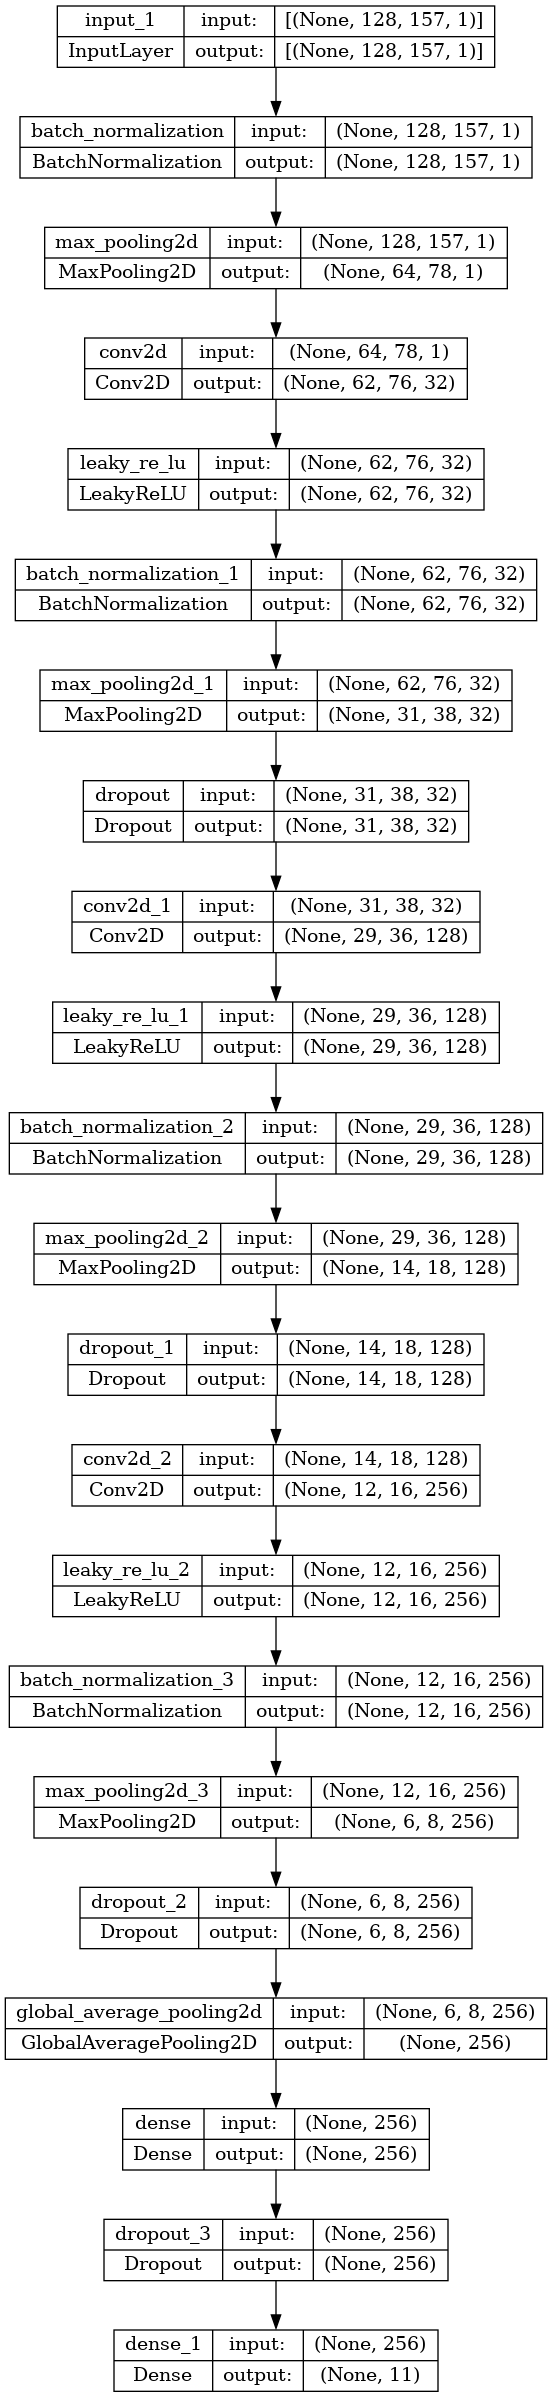

In [11]:

from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Creating Callbacks for save the best trained model.

In [12]:
call_back = [tf.keras.callbacks.ModelCheckpoint(filepath='best_model_vgg.h5', 
                                                monitor='val_accuracy',
                                                mode='max',
                                                verbose=1,
                                                save_best_only=True)]

In [13]:
# Compile the model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.SparseCategoricalAccuracy()],
            
)


In [14]:
hist = model2.fit(train_dataset, epochs=50, validation_data=val_dataset,callbacks=call_back,)


Epoch 1/50


2023-04-18 07:02:33.382327: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


194/194 [==============================] - ETA: 0s - loss: 2.1109 - accuracy: 0.2747 - sparse_categorical_accuracy: 0.2747
Epoch 1: val_accuracy improved from -inf to 0.18762, saving model to best_model_vgg.h5
194/194 [==============================] - 14s 19ms/step - loss: 2.1109 - accuracy: 0.2747 - sparse_categorical_accuracy: 0.2747 - val_loss: 2.4046 - val_accuracy: 0.1876 - val_sparse_categorical_accuracy: 0.1876
Epoch 2/50
193/194 [============================>.] - ETA: 0s - loss: 1.6284 - accuracy: 0.4475 - sparse_categorical_accuracy: 0.4475
Epoch 2: val_accuracy improved from 0.18762 to 0.30561, saving model to best_model_vgg.h5
194/194 [==============================] - 3s 16ms/step - loss: 1.6272 - accuracy: 0.4479 - sparse_categorical_accuracy: 0.4479 - val_loss: 1.9418 - val_accuracy: 0.3056 - val_sparse_categorical_accuracy: 0.3056
Epoch 3/50
193/194 [============================>.] - ETA: 0s - loss: 1.4043 - accuracy: 0.5215 - sparse_categorical_accuracy: 0.5215
Epoch 3

dict_keys(['loss', 'accuracy', 'sparse_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_sparse_categorical_accuracy'])


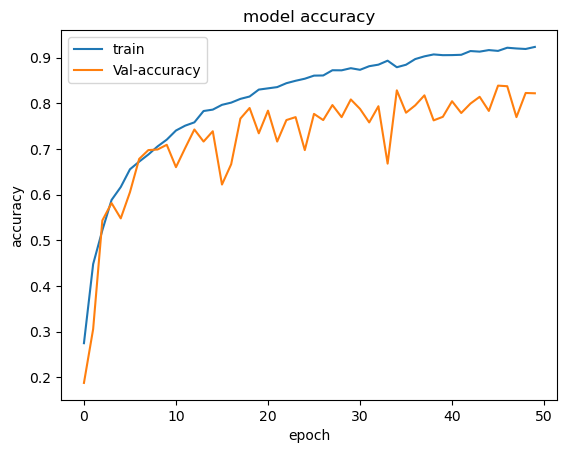

In [15]:
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
# plt.plot(hist.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val-accuracy'], loc='upper left')
plt.show()

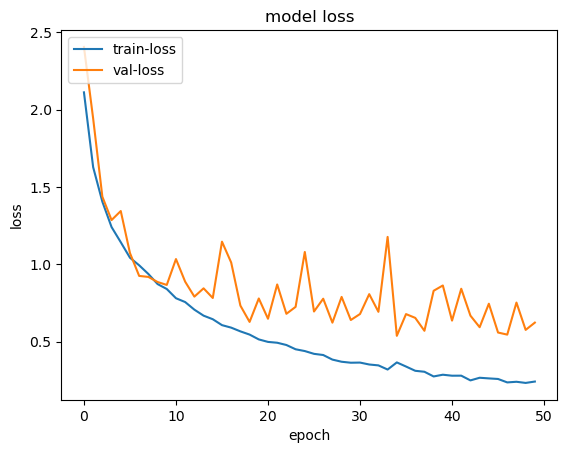

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train-loss', 'val-loss'], loc='upper left')
plt.show()

In [17]:
features, labels = val_dataset.as_numpy_iterator().next()

In [18]:
features[0]

array([[52.904747, 71.46036 , 76.21587 , ..., 79.109276, 72.92791 ,
        68.76827 ],
       [51.2798  , 61.529015, 80.      , ..., 75.059616, 80.      ,
        69.21184 ],
       [48.848915, 59.848373, 80.      , ..., 80.      , 64.49176 ,
        55.177002],
       ...,
       [80.      , 80.      , 80.      , ..., 80.      , 80.      ,
        80.      ],
       [80.      , 80.      , 80.      , ..., 80.      , 80.      ,
        80.      ],
       [80.      , 80.      , 80.      , ..., 80.      , 80.      ,
        80.      ]], dtype=float32)

In [19]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
y_pred = model2.predict(features)

1/1 [==============================] - 0s 169ms/step


In [21]:
pred = []

In [22]:
for i in y_pred:
    pred.append(i.argmax())

In [23]:
print(np.array(labels),'\n',np.array(pred))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]


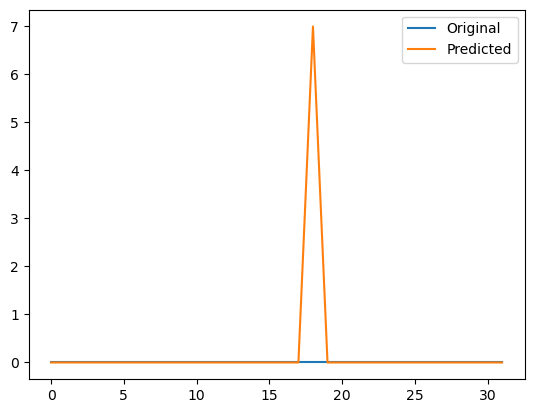

In [24]:
plt.plot(np.array(labels),label = 'Original')
plt.plot(np.array(pred), label = 'Predicted')
plt.legend()
plt.show()

# Model size Compression using onnx

In [25]:
model_path = '/kaggle/working/best_model_vgg.h5'
keras_model = tf.keras.models.load_model(model_path)

In [26]:
output_path = '/kaggle/working/model_4.onnx'
onnx_model,_ = tf2onnx.convert.from_keras(keras_model)

In [27]:
onnx.save_model(onnx_model, output_path)

In [28]:
session = ort.InferenceSession(output_path)

# Checking everything is All right after size compression.

In [29]:
audio = preprocess_audio('/kaggle/input/audio-classifier-dataset/augmented-audio/Gary Vee/203Gary Vee36.wav')

In [30]:

audio = np.expand_dims(audio, axis=-1)
audio = np.expand_dims(audio, axis=0)

In [31]:
np.argmax(model2.predict(audio))

1/1 [==============================] - 0s 149ms/step


1

In [32]:

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

output = session.run([output_name], {input_name:audio})

class_label = np.argmax(output)


In [33]:
class_label

1